In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=25dba955ab864ba03b9ad2c3e2f89cef5d00f26918cededfb0fef284d7c8ac9a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Create a SparkSession
spark = SparkSession.builder.appName("Deepfake_Classification").getOrCreate()


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


##Read Kaggle Dataset

In [ ]:
base_path = "/kaggle/input/deepfake-and-real-images/Dataset/"


##Read Drive Dataset

In [7]:
base_path = '/content/drive/MyDrive/DatasetTrimmed/'

In [49]:
train_fake_path = base_path + "Train/Fake"
train_real_path = base_path + "Train/Real"
test_fake_path = base_path + "Test/Fake"
test_real_path = base_path + "Test/Real"
validation_fake_path = base_path + "Validation/Fake"
validation_real_path = base_path + "Validation/Real"

train_fake_data = spark.read.format("image").option("dropInvalid", True).load(train_fake_path)
train_real_data = spark.read.format("image").option("dropInvalid", True).load(train_real_path)
test_fake_data = spark.read.format("image").option("dropInvalid", True).load(test_fake_path)
test_real_data = spark.read.format("image").option("dropInvalid", True).load(test_real_path)
validation_fake_data = spark.read.format("image").option("dropInvalid", True).load(validation_fake_path)
validation_real_data = spark.read.format("image").option("dropInvalid", True).load(validation_real_path)



##Preprocessing
1. Add labels to dataframe
2. Take union of partial dataframes (fake and real) to prepare the train and test dataframes

In [51]:
from pyspark.sql.functions import lit



train_fake_data = train_fake_data.withColumn('label', lit('fake'))
train_real_data = train_real_data.withColumn('label', lit('real'))

test_fake_data = test_fake_data.withColumn('label', lit('fake'))
test_real_data = test_real_data.withColumn('label', lit('real'))

validation_fake_data = validation_fake_data.withColumn('label', lit('fake'))
validation_real_data = validation_real_data.withColumn('label', lit('real'))

train_data = train_fake_data.union(train_real_data)
test_data = test_fake_data.union(test_real_data)
validation_data = validation_fake_data.union(validation_real_data)


##EDA of dataset

In [52]:
print("Train Data:")
train_data.printSchema()
#train_data.count()
#train_data.select('image.origin', 'image.data', 'label').show()

print("Test Data: ")
test_data.printSchema()
#test_data.count()
#test_data.select('image.origin', 'image.data', 'label').show()

print("Validation Data: ")
validation_data.printSchema()
#validation_data.count()
#validation_data.select('image.origin', 'image.data', 'label').show()

Train Data:
root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: string (nullable = false)

Test Data: 
root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: string (nullable = false)

Validation Data: 
root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data:

##Data Transformation and Visualization
Convert the images into np.array() and plot it using matplotlib

In [62]:
import numpy as np


def images_to_array(image_data):
  image_arrays = []
  labels = []
  for row in image_data.collect():

    img_data = row['image']['data']
    label = row['label']

    img_arr = np.array(img_data).reshape(row['image']['height'], row['image']['width'], row['image']['nChannels']).astype(np.uint8)

    img_arr = img_arr[..., ::-1]  # Convert BGR to RGB

    image_arrays.append(img_arr)
    labels.append(1 if label == 'real' else 0)

  return image_arrays, labels


train_image_arrays, train_labels = images_to_array(train_data)
test_image_arrays, test_labels = images_to_array(test_data)
validation_image_arrays, validation_labels = images_to_array(validation_data)



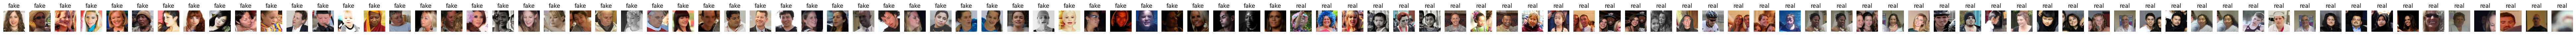

In [55]:
import matplotlib.pyplot as plt


plt.figure(figsize=(100, 30))

num_images = len(train_image_arrays)

for i, img_arr in enumerate(train_image_arrays):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img_arr)
    plt.axis('off')
    plt.title(train_labels[i], fontsize=12)

plt.show()

##Tensorflow imports for CNN model

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical


In [4]:
def create_cnn_model():
    model = models.Sequential()

    model.add(layers.Conv2D(32,(3,3),activation="relu", padding='same'))
    model.add(layers.Conv2D(32,(3,3),activation="relu", padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2, 2)))

    model.add(layers.Conv2D(64,(3,3),activation="relu", padding='same'))
    model.add(layers.Conv2D(64,(3,3),activation="relu", padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2, 2)))

    model.add(layers.Conv2D(128,(3,3),activation="relu", padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation="relu", padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128,activation="relu"))
    model.add(layers.Dense(256,activation="relu"))
    model.add(layers.Dense(1,activation="sigmoid"))

    return model

In [60]:
model = create_cnn_model()
model.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], run_eagerly=True)

##Train the model

In [63]:
X_train = np.array(train_image_arrays).astype('float32')
Y_train = np.array(train_labels)
X_val = np.array(validation_image_arrays).astype('float32')
Y_val = np.array(validation_labels)


early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)


history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val,Y_val),callbacks=[early_stopping_cb])

Epoch 1/20
4/4 [==============================] - 95s 21s/step - loss: 90.8706 - accuracy: 0.5200 - val_loss: 4.5652 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 82s 21s/step - loss: 1.9769 - accuracy: 0.5200 - val_loss: 0.8167 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 105s 29s/step - loss: 0.7552 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.5100
Epoch 4/20
4/4 [==============================] - 86s 22s/step - loss: 0.6798 - accuracy: 0.6400 - val_loss: 1.5092 - val_accuracy: 0.5000
Epoch 5/20
4/4 [==============================] - 82s 21s/step - loss: 0.9407 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5100
Epoch 6/20
4/4 [==============================] - 87s 22s/step - loss: 0.6863 - accuracy: 0.6700 - val_loss: 0.6785 - val_accuracy: 0.6500
Epoch 7/20
4/4 [==============================] - 82s 20s/step - loss: 0.7050 - accuracy: 0.5800 - val_loss: 0.6713 - val_accuracy: 0.6900
Epoch 8/20
4/4 [=========

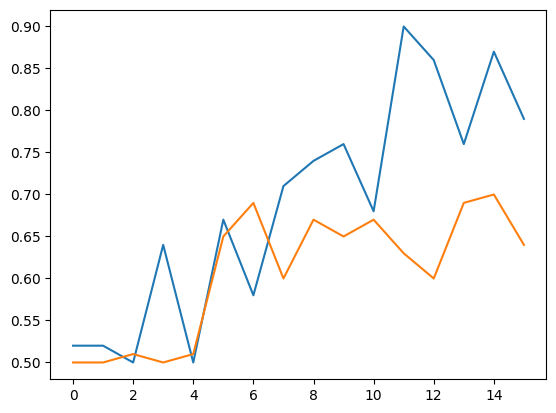

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

##Evaluate Model

In [69]:
X_test = np.array(test_image_arrays).astype('float32')
Y_test = np.array(test_labels)

model.evaluate(X_test, Y_test)

4/4 [==============================] - 29s 7s/step - loss: 0.7380 - accuracy: 0.4600


[0.7380088567733765, 0.46000000834465027]

##Confusion Matrix

In [86]:
from sklearn.metrics import confusion_matrix


predictions = model.predict(np.array(test_image_arrays))


binary_predictions = np.round(predictions).astype(int)

cm = confusion_matrix(test_labels, binary_predictions)

print("Confusion Matrix:")
print(cm)


4/4 [==============================] - 21s 4s/step
Confusion Matrix:
[[30 20]
 [34 16]]


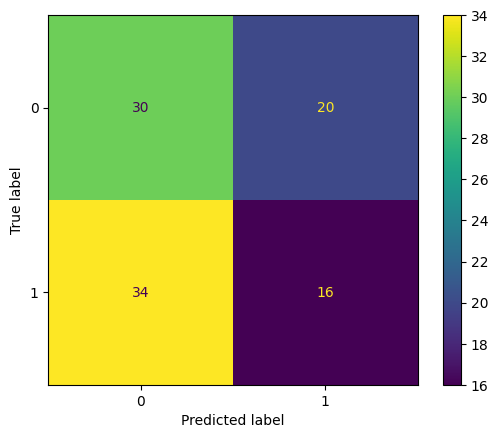

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
